# Bonus Assignment 1

![Imgur](https://i.imgur.com/4HJknC2.png)

## Scenario

Before purchasing insurances, customers are likely asked to finish a survey. The survey include questions like health conditions, habits, working condition, etc.. Insurance companies will collect and analyze the results to decide whether providing insurance service to one specific customer will be overall beneficial to the company. 

## Dataset Description

**X: Images**

Note: Due to customer privacy concerns, (simulated) participants' real response data is not provided, but instead, we've created images out of the reseponse data. Each participant's response information is captured by one image. You can think of it as a kind of encryption, and this encryption doesn't lose any information.
<br><br>


**Labels: Binary**

Note: `0` means that providing insurance service to this individual will be beneficial to the insurance company, while `1` means the opposite.

## File Description

```
Data/
├─ images/
│  ├─ 0a6a24e7ef.png
│  ├─ 0a7f251b0c.png
│  ├─ ...
├─ train.xlsx
├─ predict_me.xlsx
```
`train.xlsx`: Training data (shape: [900, 2]) has two columns `images` (file names) and `Class` (labels). <br>
`predict_me.xlsx`: One of your submission files. It has two columns `images` (file names) and `Class` (probability of `Class = 1`, empty, you need to fill in the cells). <br>
`images/`: `Data/images/` contains 1000 `.png` files. 900 of them are labeled as in `train.xlsx`, and 100 of them are not labeled as in `predict_me.xlsx`.


## Your Task

Build whatever model that you deem essential to predict the **probablility** of `Class = 1` for each image file in `predict_me.xlsx`. 

Note: Only fill in the `100` empty cells correspondingly in the second column, <font color="red">don't</font> change other cells.

## Submission

1.   `Bonous_Assignment_1 - YourStudentID.ipynb`
2.   `predict_me - YourStudentID.xlsx` (Submission example: https://drive.google.com/file/d/1jnb4UfJ529-XshEhFeB8mIBOJLUvMJt7/view?usp=sharing)



## Evaluation

The held out dataset will be evaluated with `log_loss`. 

Note: The lower `log_loss` your model score on the held out set, the higher bonus you will get.

**1. Preparation**

**1.1 Prepare for platform**

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**1.2 Data preparation**

In [4]:
import pandas as pd
# Read Data
df = pd.read_excel("/content/drive/MyDrive/Wustl/Spring 2021/565E Deep Learning/565E Bonus Project/Bonus Assignment - 1/Data/train.xlsx")
pred_df = pd.read_excel('/content/drive/MyDrive/Wustl/Spring 2021/565E Deep Learning/565E Bonus Project/Bonus Assignment - 1/Data/predict_me.xlsx')
df['Class'] = df['Class'].apply(str)
pred_df['Class'] = pred_df['Class'].apply(str)

#Split train/validation/test set
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df,train_size=0.9)
train_df, validation_df = train_test_split(train_df,train_size=0.9)
print("Training shape :\t",train_df.shape)
print("Validation shape :\t",validation_df.shape)
print("Testing X shape :\t",test_df.shape)

train_df.head(5)

Training shape :	 (729, 2)
Validation shape :	 (81, 2)
Testing X shape :	 (90, 2)


,images,Class
222,407c16b15c.png,0
405,744381c62b.png,0
159,31268c63d9.png,0
308,5619b89b93.png,0
218,3f55341035.png,0


**1.3 Configure data generator**

In [6]:
#Check the picture's mode
from PIL import Image
Image.open("/content/drive/MyDrive/Wustl/Spring 2021/565E Deep Learning/565E Bonus Project/Bonus Assignment - 1/Data/images/00cf013b32.png").mode

'RGB'

In [7]:
#Transfer image into tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

target_size_set = (372, 372)

train_datagen = ImageDataGenerator(rescale=1./255) 
train_gen = train_datagen.flow_from_dataframe(
       train_df,
       directory='/content/drive/MyDrive/Wustl/Spring 2021/565E Deep Learning/565E Bonus Project/Bonus Assignment - 1/Data/images',
       target_size=target_size_set,
       color_mode='rgb',
       class_mode='binary',
       x_col='images',
       y_col='Class',
       batch_size=32,
       shuffle=True)

val_datagen = ImageDataGenerator(rescale=1./255)
val_gen = val_datagen.flow_from_dataframe(
      validation_df,
      directory='/content/drive/MyDrive/Wustl/Spring 2021/565E Deep Learning/565E Bonus Project/Bonus Assignment - 1/Data/images',
      target_size=target_size_set,
      color_mode='rgb',
      class_mode='binary',
      x_col='images',
      y_col='Class')
    
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(
      test_df,
      directory='/content/drive/MyDrive/Wustl/Spring 2021/565E Deep Learning/565E Bonus Project/Bonus Assignment - 1/Data/images',
      target_size=target_size_set,
      color_mode='rgb',      
      class_mode='binary',
      x_col='images',
      y_col='Class')

Found 729 validated image filenames belonging to 2 classes.
Found 81 validated image filenames belonging to 2 classes.
Found 90 validated image filenames belonging to 2 classes.


**2. Modeling**

**Since it is image, a CNN model will be more accurate in predicting**

**2.1 Large CNN model**

**First See the performance of CNN. At this step, I did not set Dropout and regularization**

In [29]:
# Build sequential model
from tensorflow.keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

model=Sequential()
model.add(Conv2D(128, 3,input_shape=(372,372,3),activation="relu"))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, 3,activation="relu"))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dropout(0.2))                                                        
model.add(Dense(64,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

#Use log-loss to see the error
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['binary_crossentropy'])

# Configure EarlyStopping object
Es=EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)      

# Fit the model and record the training history for plotting purpose
history=model.fit(train_gen,
      steps_per_epoch=train_gen.n//train_gen.batch_size, 
      epochs=30,
      validation_data=val_gen,
      validation_steps=val_gen.n//val_gen.batch_size,
      callbacks=[Es])                                                         

Epoch 1/30
22/22 [==============================] - 7s 280ms/step - loss: 3.6685 - binary_crossentropy: 3.6685 - val_loss: 0.3349 - val_binary_crossentropy: 0.3349
Epoch 2/30
22/22 [==============================] - 6s 271ms/step - loss: 0.2330 - binary_crossentropy: 0.2330 - val_loss: 0.0667 - val_binary_crossentropy: 0.0667
Epoch 3/30
22/22 [==============================] - 6s 274ms/step - loss: 0.0403 - binary_crossentropy: 0.0403 - val_loss: 0.0111 - val_binary_crossentropy: 0.0111
Epoch 4/30
22/22 [==============================] - 6s 270ms/step - loss: 0.0048 - binary_crossentropy: 0.0048 - val_loss: 0.0031 - val_binary_crossentropy: 0.0031
Epoch 5/30
22/22 [==============================] - 6s 272ms/step - loss: 0.0013 - binary_crossentropy: 0.0013 - val_loss: 0.0043 - val_binary_crossentropy: 0.0043
Epoch 6/30
22/22 [==============================] - 6s 270ms/step - loss: 7.2299e-04 - binary_crossentropy: 7.2299e-04 - val_loss: 0.0024 - val_binary_crossentropy: 0.0024
Epoch 7/

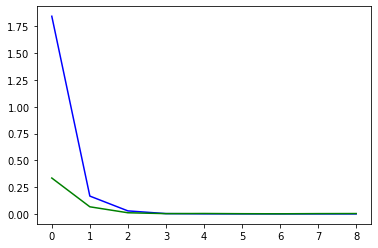

In [30]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history.history['binary_crossentropy'], color='b')
plt.plot(history.history['val_binary_crossentropy'], color='g')
plt.show()

As the validation crossentropy shown, the train crossentropy aligned with validation crossentropy after 2 epochs training. The bias is low, as well as variance. Thus no underfitting & overfitting happens.

In [31]:
# Evaluate test data accuracy.
model.evaluate(test_gen)

3/3 [==============================] - 0s 111ms/step - loss: 7.1715e-04 - binary_crossentropy: 7.1715e-04


[0.0007171497563831508, 0.0007171497563831508]

In [ ]:
The test CrossEntropy is almost 0, which is good

**3. Prediction Output**

**3.1 Configure data generator for prediction data**

In [74]:
#Transfer predict image into tensorflow using function
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions


def pred_service(model, input_image):
    pred_image = image.load_img(input_image, target_size = (372, 372))
    pred_image = image.img_to_array(pred_image)
    pred_image = np.expand_dims(pred_image, axis=0)
    
    #Scale the pixel ranging from 0~255 to fit RGB using preprocess_input
    pred_image_preprocessed = preprocess_input(pred_image)
    
    result = model.predict(pred_image_preprocessed)[0][0]

    result = 0 if result < 0.5 else 1
  
    return result

In [84]:
#Predict Data
image_dic = '/content/drive/MyDrive/Wustl/Spring 2021/565E Deep Learning/565E Bonus Project/Bonus Assignment - 1/Data/images/'

pred_result = {}
for image_path in pred_df['images']:
  input_image = image_dic+image_path
  pred_result[image_path] = pred_service(model, input_image)

In [93]:
#Output the data
answer = pd.DataFrame(pred_result.items(), columns=['image', 'Class'])
answer.to_excel('/content/drive/MyDrive/Wustl/Spring 2021/565E Deep Learning/565E Bonus Project/Bonus Assignment - 1/predict_me.xlsx')

**Appendix**

**Attention: I had already find the proper model above, the content below is just serve as personal trial**

**Exploration: Convolution Model with drop & regularization added**

In [14]:
# Build sequential model
model=Sequential()
model.add(Conv2D(128, 3,input_shape=(372,372,3),activation="relu"))
model.add(MaxPooling2D(2))
#model.add(Conv2D(64, 3,activation="relu"))
#model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dropout(0.2))                                                        
model.add(Dense(64,activation="relu", kernel_regularizer="l2"))
model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['binary_crossentropy'])

# Configure EarlyStopping object
Es=EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)      

# Fit the model and record the training history for plotting purpose
history=model.fit(train_gen,
      steps_per_epoch=train_gen.n//train_gen.batch_size, 
      epochs=30,
      validation_data=val_gen,
      validation_steps=val_gen.n//val_gen.batch_size,
      callbacks=[Es])   

Epoch 1/30
22/22 [==============================] - 9s 346ms/step - loss: 27.9765 - binary_crossentropy: 21.0006 - val_loss: 10.5703 - val_binary_crossentropy: 0.0177
Epoch 2/30
22/22 [==============================] - 7s 334ms/step - loss: 8.7823 - binary_crossentropy: 0.0874 - val_loss: 4.2171 - val_binary_crossentropy: 0.0360
Epoch 3/30
22/22 [==============================] - 7s 331ms/step - loss: 3.4258 - binary_crossentropy: 0.0360 - val_loss: 1.7749 - val_binary_crossentropy: 0.0251
Epoch 4/30
22/22 [==============================] - 7s 331ms/step - loss: 1.5123 - binary_crossentropy: 0.0288 - val_loss: 0.8915 - val_binary_crossentropy: 0.0168
Epoch 5/30
22/22 [==============================] - 7s 333ms/step - loss: 0.7779 - binary_crossentropy: 0.0180 - val_loss: 0.5253 - val_binary_crossentropy: 0.0192
Epoch 6/30
22/22 [==============================] - 7s 335ms/step - loss: 0.4541 - binary_crossentropy: 0.0107 - val_loss: 0.3127 - val_binary_crossentropy: 0.0097
Epoch 7/30
22

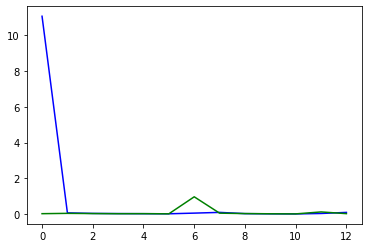

In [15]:
# Plot history
plt.plot(history.history['binary_crossentropy'], color='b')
plt.plot(history.history['val_binary_crossentropy'], color='g')
plt.show()

In [16]:
# Evaluate test data accuracy.
model.evaluate(test_gen)

3/3 [==============================] - 0s 102ms/step - loss: 0.0584 - binary_crossentropy: 0.0050


[0.0584077313542366, 0.004978178068995476]

The result shows that CNN with drop & regularization does not out perform large CNN above though the model here finally has an aligned train & validation CrossEntropy.

**The reason is that the image we are going to identify is composed of vertical lines. As a result, no matter how non-linear we set for the CNN, there will be no overfitting problem aroused.**